In [87]:
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
from astropy.visualization import ZScaleInterval
from glob import glob
import os
import pandas as pd

In [103]:
class MultiStepObject:
	def __init__(self, folder):
		"""
		Acts as a container for MOS data at Stage 2 (cals), Stage 2 + BNBG (BNBG) and backgrounds (bkg), and Stage 3 (s2d).

		Parameters
		----------
		folder : str
			Path to the folder
		"""
		def get_sorted_files(folder, pattern):
			files = glob(os.path.join(folder, pattern))
			files.sort()
			return files

		cal_list = get_sorted_files(folder, '*nrs1_cal.fits') + get_sorted_files(folder, '*nrs2_cal.fits')
		bkg_list = get_sorted_files(folder, '*nrs1_bkg-BNBG.fits') + get_sorted_files(folder, '*nrs2_bkg-BNBG.fits')
		BNBG_list = get_sorted_files(folder, '*nrs1_cal-BNBG.fits') + get_sorted_files(folder, '*nrs2_cal-BNBG.fits')

		# Assuming lists are of format
		# [001_nrs1, 002_nrs1, 003_nrs1, 001_nrs2, 002_nrs2, 003_nrs2]

		s2d_list = glob(os.path.join(folder, 'Final/*_s2d.fits'))
		print("Opening CALs")
		self.cal_list = [fits.open(_) for _ in cal_list]
		self.cal_list = [[_ for _ in cal if _.name == "SCI"] for cal in self.cal_list]
		self.cal_sources = [[_.header["sourceid"] for _ in cal] for cal in self.cal_list]
		print("Opening BKGs")
		self.bkg_list = [fits.open(_) for _ in bkg_list]
		self.bkg_list = [[_ for _ in bkg if _.name == "SCI"] for bkg in self.bkg_list]
		print("Opening BNBGs")
		self.BNBG_list = [fits.open(_) for _ in BNBG_list]
		self.BNBG_list = [[_ for _ in BNBG if _.name == "SCI"] for BNBG in self.BNBG_list]
		print("Opening S2Ds")
		self.s2d_list = [fits.open(_) for _ in s2d_list]
		self.s2d_sources = [s2d[1].header["sourceid"] for s2d in self.s2d_list]

	def plot(self, source_id):
		cal_list = self._get_hdus_by_source(source_id, self.cal_list)
		bkg_list = self._get_hdus_by_source(source_id, self.bkg_list)
		bnbg_list = self._get_hdus_by_source(source_id, self.BNBG_list)

		isnrs1 = not all(_ is None for _ in cal_list[:3])
		isnrs2 = not all(_ is None for _ in cal_list[3:])


	@staticmethod
	def _plot(cal, bkg, bnbg, s2d, sourceid):
		fig = plt.figure(constrained_layout=True, figsize=(16,8))
		gs = fig.add_gridspec(4, 5)
		ax_cal = [fig.add_subplot(gs[i, 0]) for i in range(3)]
		ax_bkg = [fig.add_subplot(gs[i, 1]) for i in range(3)]
		ax_bnbg = [fig.add_subplot(gs[i, 2]) for i in range(3)]
		ax_spec = fig.add_subplot(gs[3, :3])
		ax_s2d = fig.add_subplot(gs[:, 3])
		ax_con = fig.add_subplot(gs[:, 4])
		plt.show()


	def _get_hdus_by_source(self, source_id, data_list):
		# hdus, sids are lists, one for each 00N_nrsM file (N=1,2,3, M=1,2)
		# next will return the first element of all hdu that verify sid = source_id
		# if none is found, returns None
		return [
			next((hdu for hdu, sid in zip(hdus, sids) if sid == source_id), None)
			for hdus, sids in zip(data_list, self.cal_sources)
		]



In [95]:
MSO = MultiStepObject("/home/tim-dewachter/Documents/Thèse/BetterNIRSpecBackground/mastDownload/JWST/CEERS-NIRSPEC-P5-PRISM-MSATA")

Opening CALs
Opening BKGs
Opening BNBGs
Opening S2Ds


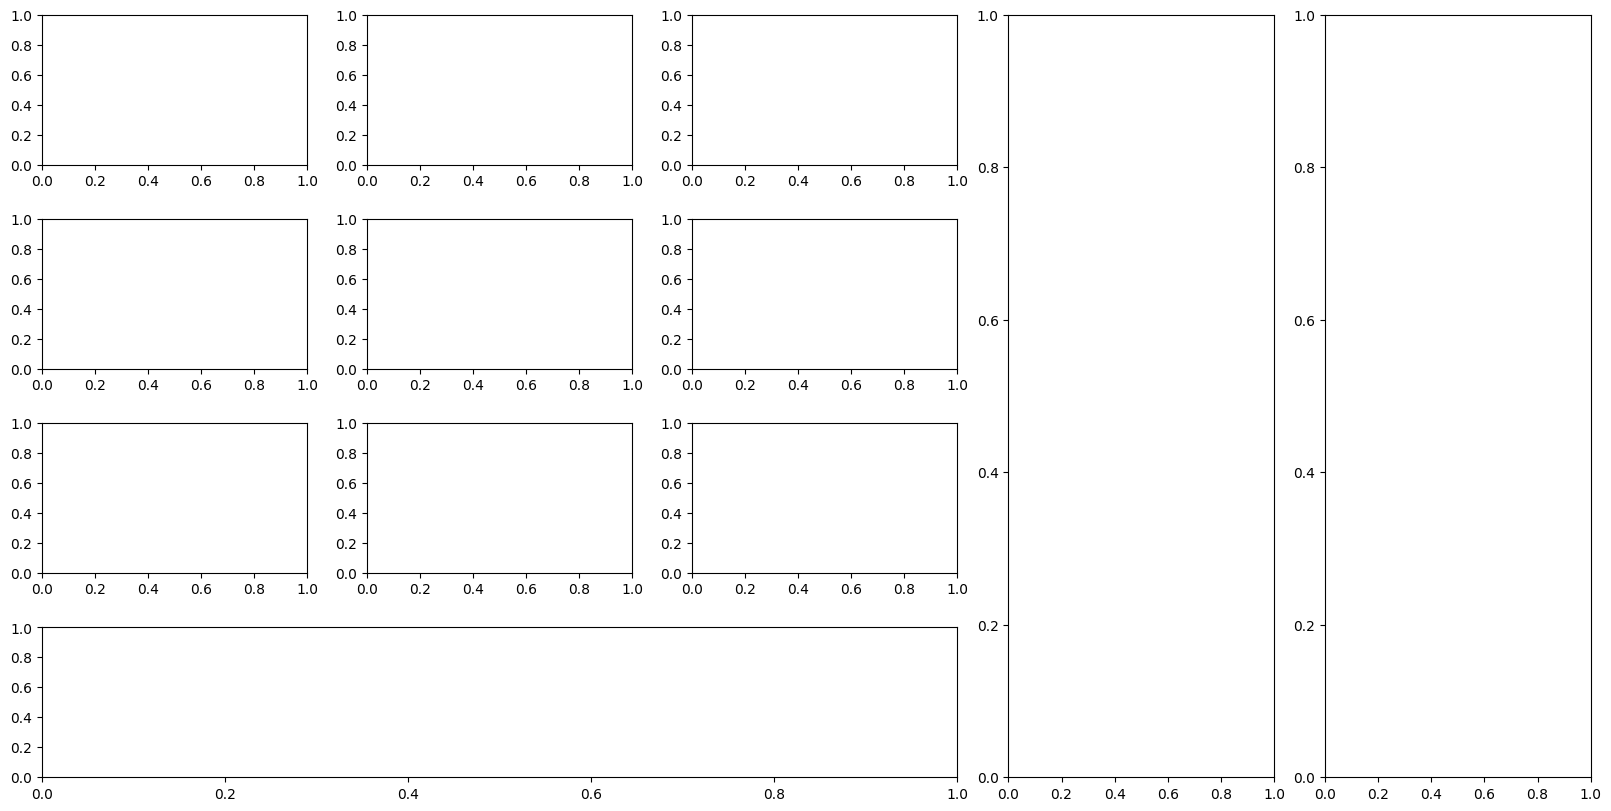

In [104]:
MultiStepObject._plot(None,None,None,None,None)